In [3]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import base64
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.cluster import DBSCAN
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile

In [2]:
pip install kneed

  Using cached kneed-0.8.5-py3-none-any.whl (10 kB)
Note: you may need to restart the kernel to use updated packages.


In [35]:
tracks_ready=pd.read_csv('tracks_ready.csv',sep=',')

Откуда сперла

https://www.reneshbedre.com/blog/dbscan-python.html

In [ ]:
tracks_ready_small=tracks_ready[['id','centroid_lon','centroid_lat','start_dttm','final_part_of_day_in_word','weekend','start_dttm_day']]

In [ ]:
customers=np.unique(tracks_ready_small['id'])

In [ ]:
ids=[]
clusters_list=[]
kneedle_list=[]
i=1
for id in customers:
    if len(tracks_ready_small[tracks_ready_small['id']==id])==1:
        ids.append([id]*len(tracks_ready_small[tracks_ready_small['id']==id]))
        clusters_list.append([1]*len(tracks_ready_small[tracks_ready_small['id']==id]))
        kneedle_list.append([0]*len(tracks_ready_small[tracks_ready_small['id']==id]))
    else:
        if len(tracks_ready_small[tracks_ready_small['id']==id])<5:
            nbrs = NearestNeighbors(n_neighbors = len(tracks_ready_small[tracks_ready_small['id']==id])).fit(tracks_ready_small[tracks_ready_small['id']==id][['centroid_lon','centroid_lat']])
        else:
            # n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros)
            nbrs = NearestNeighbors(n_neighbors = 5).fit(tracks_ready_small[tracks_ready_small['id']==id][['centroid_lon','centroid_lat']])
        # Find the k-neighbors of a point
        neigh_dist, neigh_ind = nbrs.kneighbors(tracks_ready_small[tracks_ready_small['id']==id][['centroid_lon','centroid_lat']])
        # sort the neighbor distances (lengths to points) in ascending order
        # axis = 0 represents sort along first axis i.e. sort along row
        sort_neigh_dist = np.sort(neigh_dist, axis = 0)
        try:
            k_dist = sort_neigh_dist[:, 2]
        except IndexError:
            k_dist = sort_neigh_dist[:, 1]
        kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, 
                            curve = "concave", direction = "increasing", online=True)
        try:
            if kneedle.knee_y>0:
                kneedle_cuurent=kneedle.knee_y
            else:
                kneedle_cuurent=0.001
            clusters = DBSCAN(eps = kneedle_cuurent, min_samples = 1).fit(tracks_ready_small[tracks_ready_small['id']==id][['centroid_lon','centroid_lat']])    
            ids.append([id]*len(tracks_ready_small[tracks_ready_small['id']==id]))
            clusters_list.append(clusters.labels_)
            kneedle_list.append([kneedle_cuurent]*len(tracks_ready_small[tracks_ready_small['id']==id]))
        except TypeError:
            ids.append([id]*len(tracks_ready_small[tracks_ready_small['id']==id]))
            clusters_list.append([1]*len(tracks_ready_small[tracks_ready_small['id']==id]))
            kneedle_list.append([0]*len(tracks_ready_small[tracks_ready_small['id']==id]))
        # get cluster labels - label each obs
        # check unique clusters
        #set(clusters.labels_)
        #print(Counter(clusters.labels_))    
        #p = sns.scatterplot(data = tracks_ready_small[tracks_ready_small['id']==id][['centroid_lon','centroid_lat']], x = "centroid_lon", y = "centroid_lat", hue = clusters.labels_, legend = "full", palette = "deep")
        #plt.show()


In [ ]:
import itertools
ids_list2 = list(itertools.chain(*ids))
clusters=list(itertools.chain(*clusters_list))
kn=list(itertools.chain(*kneedle_list))
clustering_result=pd.DataFrame(ids_list2,columns=['id'])
clustering_result['clusters']=clusters
clustering_result['kneedle']=kn
clustering_result['help']=1

In [ ]:
tracks_ready_small['help']=1

In [ ]:
checking_df=pd.pivot_table(tracks_ready_small,index='id',values='help',aggfunc=sum).merge(pd.pivot_table(clustering_result,index='id',values='help',aggfunc=sum),on='id')
checking_df['correct_result']=checking_df['help_x']==checking_df['help_y']
checking_df[checking_df['correct_result']==False]

In [ ]:
clustering_result.columns

In [ ]:
tracks_ready['clusters_settl']=clustering_result['clusters']
tracks_ready['kneedle']=clustering_result['kneedle']


In [ ]:
def find_dist1(lat1,lon1,lat2,lon2):
    try:
        lat1=lat1/57.36049
        lat2=lat2/57.36049
        lon1=lon1/57.36049
        lon2=lon2/57.36049
        return 2*6371*np.arcsin((np.sin((lat2-lat1)/2)**2+np.cos(lat1)*np.cos(lat2)*np.sin((lon1-lon2)/2)**2)**0.5)

    except ValueError:
        return 0

In [ ]:
tracks_ready['eps']=list(map(find_dist1,[0]*len(tracks_ready),[0]*len(tracks_ready),tracks_ready['kneedle'],[0]*len(tracks_ready)))


In [ ]:
plt.hist(tracks_ready[tracks_ready['kneedle']<1]['eps'])
plt.plot()

In [ ]:
tracks_ready[tracks_ready['kneedle']<1]['eps'].describe()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np

# Create a list to hold the distortions (inertia) for each number of clusters
distortions = []

# Generate some sample data (replace this with your actual dataset)
# X = ...

# Fit KMeans and calculate the distortions for a range of number of clusters
for k in range(1, 11):
    kmeanModel = KMeans(n_clusters=k).fit(tracks_ready['kneedle'].values.reshape(-1,1))
    kmeanModel.fit(tracks_ready['kneedle'].values.reshape(-1,1))
    distortions.append(sum(np.min(cdist(tracks_ready['kneedle'].values.reshape(-1,1), kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / tracks_ready['kneedle'].values.reshape(-1,1).shape[0])

# Plot the elbow graph
plt.plot(range(1, 11), distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show() 

Короче, тут аж критерий существует для поиска оптимальной точки - тут можно посмотреть код https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion

Но он ТАААААК долго считался что я решила довериться графику и теоретиечскому обоснованию что 5 кластеров - это окау

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(tracks_ready['kneedle'].values.reshape(-1,1))


In [ ]:
tracks_ready['5 clusters for settlement level']=kmeans.labels_

разница средних в километрах между кластерами и кол-во наблюдений. Получаем 5 типов уровня оседласти с разными уровнями "разброса"

In [ ]:
tracks_ready['help']=1

In [ ]:
pd.pivot_table(tracks_ready,index='5 clusters for settlement level',values=('eps','help'),aggfunc={'eps':'mean','help':sum})

In [ ]:
np.median(tracks_ready[tracks_ready['5 clusters for settlement level']==0]['kneedle'])

# For different time zones in day

In [49]:
tracks_ready.columns

Index(['id', 'start_dttm', 'end_dttm', 'centroid_wkt', 'centroid_lon',
       'centroid_lat', 'start_dttm_day', 'h3_9', 'time_spent', 'current_date',
       ...
       'num of days appear fr', 'number of visits of hex per day',
       'time_spent_avr_h', 'weekend', 'evening', 'morning', 'night',
       'whole day', 'whole day end', 'working hours'],
      dtype='object', length=139)

Шо имеем - для каждой части дня для eps=0.01  насчитали кучу кластеров по геолокациям. Кол-во кластеров можно сделать меньше, увеличив это значение. Может быть нужно бдет поэксперементировать, кол-во кластеров зависит от наших намерений скорее. Как мне кажется тут больше важен алгоритм и что он способен выдать, чем сам результат конекретно сейчас. 

In [26]:
np.unique(tracks_ready['final_part_of_day_in_word'])

array(['evening', 'morning', 'night', 'whole day', 'whole day end',
       'working hours'], dtype=object)

In [36]:
for pds in np.unique(tracks_ready['final_part_of_day_in_word']):
#pds='working hours'
    df_s=tracks_ready[tracks_ready['final_part_of_day_in_word']==pds][['centroid_lon','centroid_lat','id','start_dttm','final_part_of_day_in_word']]
    X=tracks_ready[tracks_ready['final_part_of_day_in_word']==pds][['centroid_lon','centroid_lat']]
    nbrs = NearestNeighbors(n_neighbors = 5).fit(X)
    neigh_dist, neigh_ind = nbrs.kneighbors(X)
    sort_neigh_dist = np.sort(neigh_dist, axis = 0)
    k_dist = sort_neigh_dist[:, 2]
    kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, 
                        curve = "concave", direction = "increasing", online=True)
    #kneedle_cuurent=kneedle.knee_y
    kneedle_current=0.001 #автоматически подбирается хреново для такого кол-ва, посмотрела среднее значение из предыдущего куска кода
    clusters = DBSCAN(eps = kneedle_current, min_samples = 1).fit(X)    
    df_s[pds]=clusters.labels_
    tracks_ready=pd.merge(tracks_ready,df_s, how='left',on=['centroid_lon','centroid_lat','id','start_dttm','final_part_of_day_in_word'])
    print(pds)



evening
morning
night
whole day
whole day end
working hours


In [37]:
for col in np.unique(tracks_ready['final_part_of_day_in_word']):
    print(len(np.unique(tracks_ready[col])))
    

243
290
330
415
266
239


In [38]:
tracks_ready['count']=1

In [46]:
pd.pivot_table(tracks_ready,index='whole day',values='count',aggfunc=sum).sort_values(by='count')

,count
whole day,
413.0,1
114.0,1
319.0,1
321.0,1
212.0,1
...,...
13.0,1486
3.0,1533
7.0,1597


In [ ]:
tracks_ready.to_csv('C:/Users/Asus/Downloads/tracks_ready.csv',sep=',',index=False)

In [86]:
tracks_ready[tracks_ready['id']==id]

,id,start_dttm,end_dttm,centroid_wkt,centroid_lon,centroid_lat,start_dttm_day,h3_9,time_spent,current_date,...,morning,night,whole day,whole day end,working hours,clusters_settl,kneedle,eps,5 clusters for settlement level,help
0,0,2023-03-03 00:18:43,2023-03-03 11:44:19,POINT (30.404122 60.031678),30.404122,60.031678,3,891106a9817ffff,685.600000,2023-03-03,...,NaN,NaN,NaN,0.0,NaN,0,0.002826,0.313831,1,1
1,0,2023-03-03 13:17:33,2023-03-03 14:59:41,POINT (30.404122 60.031678),30.404122,60.031678,3,891106a9817ffff,102.133333,2023-03-03,...,NaN,NaN,NaN,NaN,0.0,0,0.002826,0.313831,1,1
2,0,2023-03-03 19:28:07,2023-03-03 21:57:15,POINT (30.404122 60.031678),30.404122,60.031678,3,891106a9817ffff,149.133333,2023-03-03,...,NaN,NaN,NaN,NaN,NaN,0,0.002826,0.313831,1,1
3,0,2023-03-03 23:39:50,2023-03-04 05:35:30,POINT (30.404122 60.031678),30.404122,60.031678,4,891106a9817ffff,355.666667,2023-03-03,...,NaN,NaN,NaN,0.0,NaN,0,0.002826,0.313831,1,1
4,0,2023-03-04 05:35:30,2023-03-04 08:35:30,POINT (30.397536 60.036734),30.397536,60.036734,4,891106a9d4bffff,180.000000,2023-03-04,...,0.0,NaN,NaN,NaN,NaN,1,0.002826,0.313831,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0,2023-03-20 06:27:23,2023-03-20 07:27:23,POINT (30.397536 60.036734),30.397536,60.036734,20,891106a9d4bffff,60.000000,2023-03-20,...,0.0,NaN,NaN,NaN,NaN,1,0.002826,0.313831,1,1
98,0,2023-03-20 07:27:23,2023-03-20 08:37:21,POINT (30.404122 60.031678),30.404122,60.031678,20,891106a9817ffff,69.966667,2023-03-20,...,0.0,NaN,NaN,NaN,NaN,0,0.002826,0.313831,1,1
99,0,2023-03-20 09:11:14,2023-03-20 12:40:59,POINT (30.419253 60.024696),30.419253,60.024696,20,891106a987bffff,209.750000,2023-03-20,...,NaN,NaN,NaN,NaN,0.0,2,0.002826,0.313831,1,1
100,0,2023-03-20 13:56:44,2023-03-20 16:01:33,POINT (30.419253 60.024696),30.419253,60.024696,20,891106a987bffff,124.816667,2023-03-20,...,NaN,NaN,NaN,NaN,0.0,2,0.002826,0.313831,1,1


In [93]:
ids=np.unique(tracks_ready['id'])

Если нужно будет что то визаулизировать

                help
clusters_settl      
0                 59
1                 28
                                 help
5 clusters for settlement level      
0                                  87


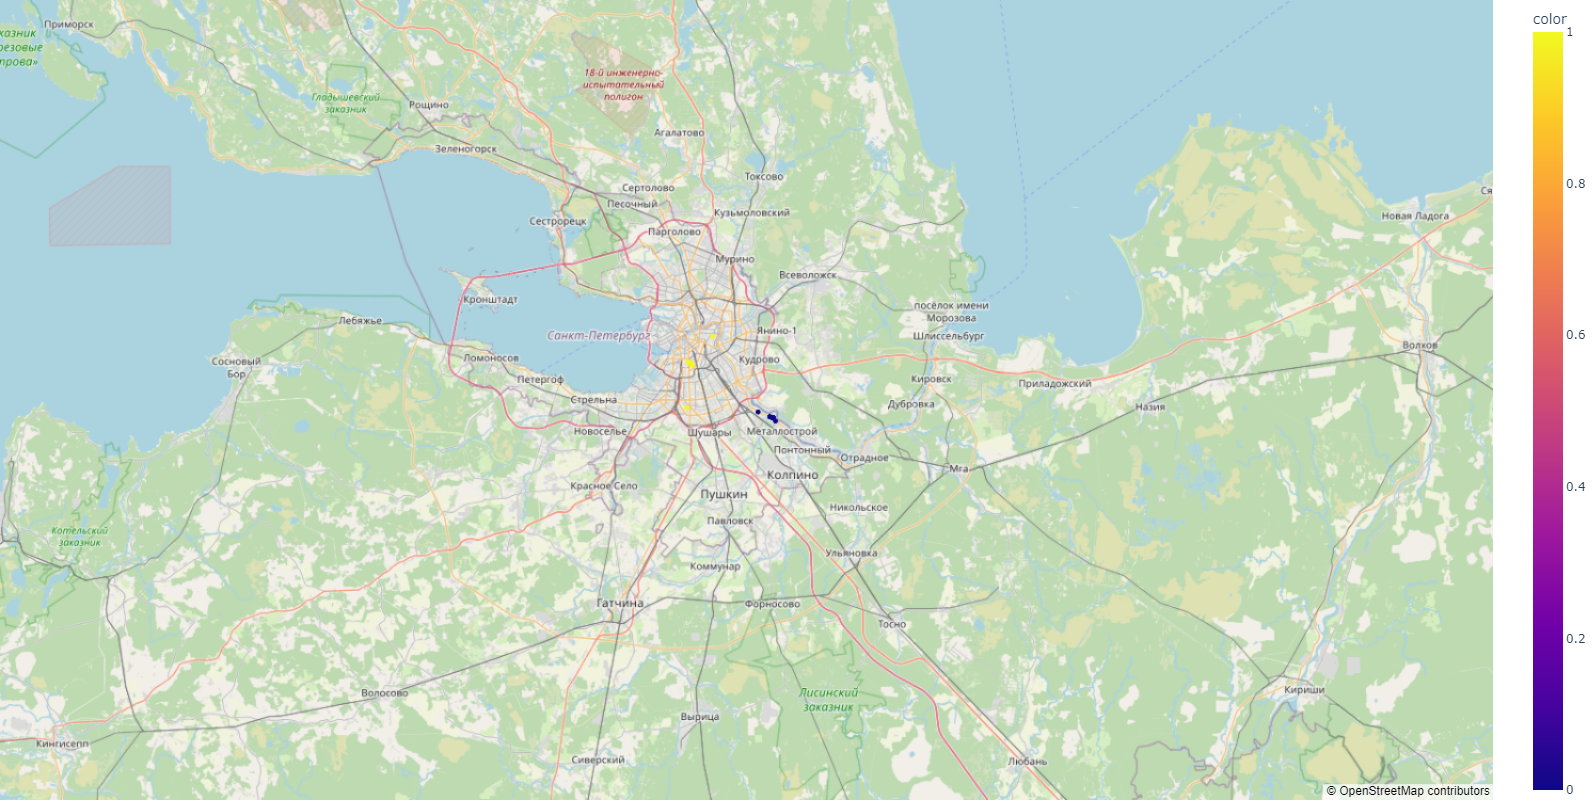

In [98]:

import plotly.express as px

color_scale = [(0, 'orange'), (1,'red')]
id=ids[1248]
print(pd.pivot_table(tracks_ready[tracks_ready['id']==id],index='clusters_settl',values='help',aggfunc=sum))
print(pd.pivot_table(tracks_ready[tracks_ready['id']==id],index='5 clusters for settlement level',values='help',aggfunc=sum))

fig1 = px.scatter_mapbox(tracks_ready[tracks_ready['id']==id][['centroid_lon','centroid_lat']], 
                        lat='centroid_lat', 
                        lon='centroid_lon', 
                        #hover_name="name", 
                        #hover_data=["name"],
                        color=tracks_ready[tracks_ready['id']==id]['clusters_settl'].values,
                        #color_continuous_scale=color_scale,
                        #size="Listed",
                        zoom=8, 
                        height=800,
                        width=800)

fig1.update_layout(mapbox_style="open-street-map")
fig1.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig1.show()

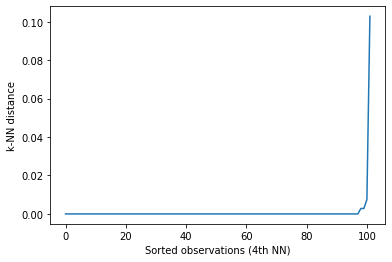

In [15]:
import matplotlib.pyplot as plt
plt.plot(k_dist)
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()